In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [5]:
# There is a Crop layer that the HED network uses which is not implemented by 
# default so we need to provide our own implementation of this layer.
#Without the crop layer, the final result will be shifted to the right and bottom
#cropping part of the image
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]




In [6]:
# The pre-trained model that OpenCV uses has been trained in Caffe framework
#Download from the link above
protoPath = "C:/Users/Peter/Desktop/MACHINE LEARNING METAL MICROSTRUCTURE/hed-master/examples/hed/deploy.prototxt"
modelPath = "C:/Users/Peter/Desktop/MACHINE LEARNING METAL MICROSTRUCTURE/hed-master/examples/hed/hed_pretrained_bsds.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

In [7]:
# register our crop layer with the model
cv2.dnn_registerLayer("Crop", CropLayer)


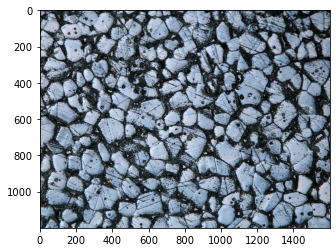

In [8]:
img = cv2.imread("E:/SS DATASET V2/2.jpg")
plt.imshow(img)
(H, W) = img.shape[:2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


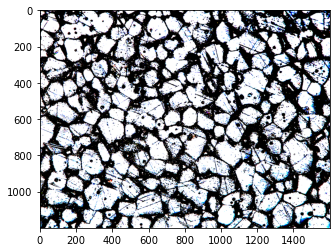

In [9]:
mean_pixel_values= np.average(img, axis = (0,1))
blob = cv2.dnn.blobFromImage(img, scalefactor=0.7, size=(W, H),
                             #mean=(mean_pixel_values[0], mean_pixel_values[1], mean_pixel_values[2]),
                             mean=(105, 117, 123),
                             swapRB= False, crop=False)

#View image after preprocessing (blob)
blob_for_plot = np.moveaxis(blob[0,:,:,:], 0,2)
plt.imshow(blob_for_plot)

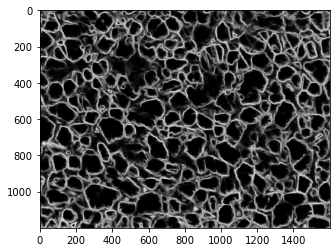

In [10]:
# set the blob as the input to the network and perform a forward pass
# to compute the edges
net.setInput(blob)
hed = net.forward()
hed = hed[0,0,:,:]  #Drop the other axes 
#hed = cv2.resize(hed[0, 0], (W, H))
hed = (255 * hed).astype("uint8")  #rescale to 0-255

plt.imshow(hed, cmap='gray')

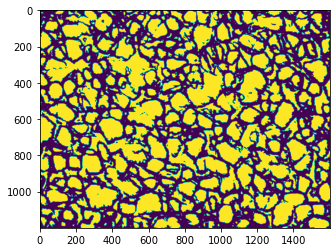

In [16]:
blur = cv2.GaussianBlur(hed, (3,3), 0)
thresh = cv2.threshold(blur, 40, 250, cv2.THRESH_BINARY_INV)[1]
plt.imshow(thresh)

In [17]:
cv2.imwrite("D:/GS/HED V2/1HED.jpg", thresh)

True

In [19]:
# n = the number of files to sort through
n = 40

In [20]:
#Run and save all 40 images so it can go faster

for t in range(n):
    img = cv2.imread("E:/SS DATASET V2/" + str(t+1) + ".jpg")
    mean_pixel_values= np.average(img, axis = (0,1))
    blob = cv2.dnn.blobFromImage(img, scalefactor=0.7, size=(W, H),
                             #mean=(mean_pixel_values[0], mean_pixel_values[1], mean_pixel_values[2]),
                             mean=(105, 117, 123),
                             swapRB= False, crop=False)

    
    net.setInput(blob)
    hed = net.forward()
    hed = hed[0,0,:,:]  #Drop the other axes 
    #hed = cv2.resize(hed[0, 0], (W, H))
    hed = (255 * hed).astype("uint8")  #rescale to 0-255
    blur = cv2.GaussianBlur(hed, (3,3), 0)
    thresh = cv2.threshold(blur, 40, 250, cv2.THRESH_BINARY_INV)[1]
    cv2.imwrite("D:/GS/HED V2/" + str(t+1) + "HED.jpg", thresh)

In [48]:
img = cv2.imread("D:/GS/HED V2/1HED.jpg")

In [52]:
area_threshold = 100
n = 40

In [79]:
#loop through to get rid of all areas below 100
# 100 pixel area is about 5 micron diameter

for t in range(n):    

   

    img = cv2.imread("D:/GS/HED V2/"+ str(t+1) + "HED.jpg")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Draw the contours on the image
    cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
    black = np.zeros_like(img)


    # Iterate over the contours
    for c in contours:
        # If the contour area is below the threshold, draw it on the black image
        if cv2.contourArea(c) > area_threshold:
            cv2.drawContours(black, [c], -1, (255, 255, 255), -1)
            # Otherwise, draw it on the original image
        else:
             cv2.drawContours(img, [c], -1, (0, 255, 0), 2)

    # Save the image
    cv2.imwrite('D:/GS/FilteredHEDV2/FHED' + str(t+1) + '.jpg', black)

In [66]:
black = np.zeros_like(img)
cv2.imwrite('D:/GS/HED V2/output.jpg', black)


True

In [68]:
# Conversions from pixels to micron and microns to pixels

pixels = 225
microns = 100
scale = pixels/microns
M2P = scale
P2M = 1/scale

row_length = 1600*P2M
col_length = 1200*P2M


In [22]:
# n = the number of files to sort through
n = 40

# Choose the value to count (in this case, 1)
value = 255

# Initialize a counter
count = 0

# number of rows
numrows = 1200

# number of columns
numcols = 1600

#zeros matrix for the grain measurements x = rows y = columns
Total_Grains_X = np.zeros((1200, 40))
Total_Grains_Y = np.zeros((1600, 40))

In [132]:
#Final For Loop For Line Intercept Method

for t in range(n):

    img =cv2.imread("D:/GS/FilteredHEDV2/FHED" + str(t+1) + ".jpg", 0)
    ret, thresh = cv2.threshold(img,90,255,cv2.THRESH_BINARY)
    diff_x = np.diff(thresh, axis=1)
    diff_y = np.diff(thresh, axis=0)
    
    
    for x in range(numrows):
        # Initialize a counter
        count = 0
        # Iterate over the elements of the row
        for element in diff_x[x, :]:
            if element == value:
                count += 1
        Total_Grains_X[x, t] = count
        
    for y in range(numcols-1):
        # Initialize a counter
        count = 0
        # Iterate over the elements of the row
        for element in diff_y[:, y]:
            if element == value:
                count += 1
        Total_Grains_Y[y, t] = count


In [203]:
#check for zeros
value_zero = 0

# Initialize a counter
count = 0

#just change the X and Y and the col number (a lot of zeros is a bad measure)
for element in Total_Grains_X[:,15]:
    if element == value_zero:
        count += 1
print(count)

0


In [135]:
# Save the numpy array as a CSV

# save the array to a CSV file
np.savetxt("D:/GS/PAPER DATA and FIGURES/CSV Grain Data/Total_Grains_Y_HED.csv", Total_Grains_Y, delimiter=",")
np.savetxt("D:/GS/PAPER DATA and FIGURES/CSV Grain Data/Total_Grains_X_HED.csv", Total_Grains_X, delimiter=",")

In [146]:
#set all the zeros to one for averaging purposes

import numpy as np

Total_Grains_X[np.where(Total_Grains_X == 0)] = 1
Total_Grains_Y[np.where(Total_Grains_Y == 0)] = 1

In [147]:
AVG_GrainX_HED = row_length/Total_Grains_X
AVG_GrainY_HED = col_length/Total_Grains_Y

In [148]:
AVG_GrainY_Grad[1599,:]

IndexError: index 1599 is out of bounds for axis 0 with size 1599

In [149]:
#delete column 1599 from AVG_GrainY_ManThresh it is messing up values
# all values are 533.3333???
AVG_GrainY_Grad = np.delete(AVG_GrainY_Grad, 1599, axis=0)

IndexError: index 1599 is out of bounds for axis 0 with size 1599

In [150]:
AVG_GrainY_Grad.shape

(1599, 40)

In [151]:
# Save the numpy array as a CSV

# save the array to a CSV file
np.savetxt("D:/GS/PAPER DATA and FIGURES/CSV Grain Data/AVG_GrainY_HED.csv", AVG_GrainY_HED, delimiter=",")
np.savetxt("D:/GS/PAPER DATA and FIGURES/CSV Grain Data/AVG_GrainX_HED.csv", AVG_GrainX_HED, delimiter=",")

In [152]:
meanX = np.mean(AVG_GrainX_HED)
meanY = np.mean(AVG_GrainY_HED)
STDX = np.std(AVG_GrainX_HED)
STDY = np.std(AVG_GrainY_HED)

In [153]:
print(meanX)
print(meanY)

33.053068388859394
34.30826332981063


In [154]:
print(STDX)
print(STDY)

6.528389446847214
14.21081141462441


In [191]:
import scipy.stats as stats
from scipy.stats import kde

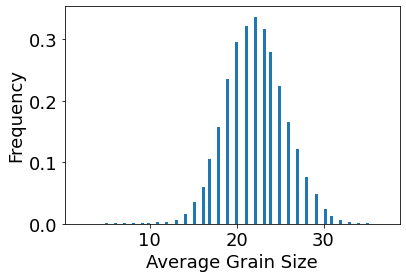

In [221]:
values = Total_Grains_X.flatten()
bins = 100

# plot the histogram
#plt.hist(values, bins, range=(20,60))

# Plot the histogram
plt.hist(values, bins, density=True, linewidth=16)


plt.xlabel("Average Grain Size", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

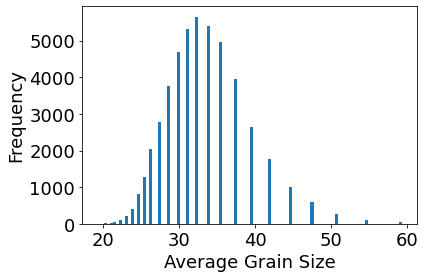

In [234]:
values = AVG_GrainX_HED.flatten()
indices = np.where(values > 60)
values = np.delete(values, indices)
bins = 100

# Plot the histogram
plt.hist(values, bins, linewidth=2)


plt.xlabel("Average Grain Size", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

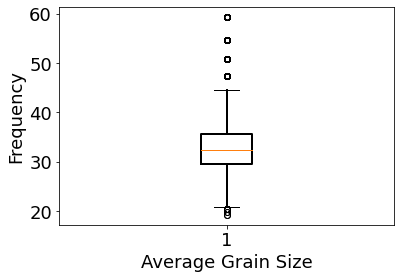

In [233]:
values = AVG_GrainX_HED.flatten()
indices = np.where(values > 60)
values = np.delete(values, indices)

# Plot the box and whisker plot
plt.boxplot(values, boxprops=dict(linewidth=2), whiskerprops=dict(linewidth=2))

# Add a title and labels
plt.xlabel("Average Grain Size", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)

# Show the plot
plt.show()

In [236]:
Total_Grains_Y.shape

(1600, 40)

In [241]:
np.unique(Total_Grains_X)

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29., 30., 31., 32., 33., 34., 35., 36., 37.])

In [238]:
print(Total_Grains_Y[1,:])

[11.  6. 12. 11.  6. 13.  9. 12. 13. 11.  8. 12. 10.  9. 11.  8. 12. 13.
 11.  7.  7.  8. 13. 15. 13. 11. 12. 11.  9.  8.  9. 10. 14. 11. 15. 15.
  7. 12.  7.  7.]


In [213]:
print(Total_Grains_X[2,:])

[25. 20. 20. 20. 24. 22. 17. 16. 17. 19. 17. 20. 23. 16. 17. 19. 23. 18.
 14. 16. 20. 13. 21. 20. 20. 15. 25. 25. 17. 16. 23. 20. 21. 16. 14. 21.
 25. 16. 18. 15.]


In [211]:
print(Total_Grains_X[0,:])

[16. 15. 13. 15. 20. 18. 12. 13. 13. 18. 12. 15. 14. 14. 16. 14. 16. 17.
 11. 12. 16. 11. 18. 20. 15. 11. 19. 19. 10. 11. 14. 16. 18. 11. 12. 14.
 17. 11. 17. 11.]


In [207]:
#check for zeros
value_zero = 32

# Initialize a counter
count = 0

#just change the X and Y and the col number (a lot of zeros is a bad measure)
for element in AVG_GrainX_HED[:,15]:
    if element == value_zero:
        count += 1
print(count)

0


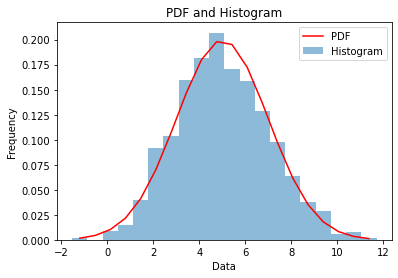

In [167]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some random data
data = np.random.normal(5, 2, 1000)

# Compute the bin edges and bin centers
bin_edges = np.histogram(data, bins=20)[1]
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

# Compute the probability density function
pdf = stats.norm.pdf(bin_centers, 5, 2)

# Plot the distribution
plt.plot(bin_centers, pdf, color='red', label='PDF')

# Plot the histogram
plt.hist(data, bins=20, density=True, alpha=0.5, label='Histogram')

# Add a legend
plt.legend()

# Add a title and labels
plt.title("PDF and Histogram")
plt.xlabel("Data")
plt.ylabel("Frequency")

# Show the plot
plt.show()

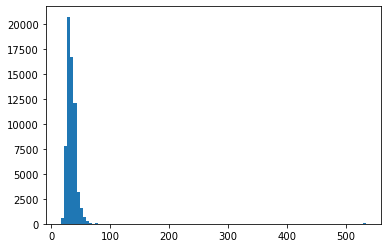

In [157]:
values = AVG_GrainY_HED.flatten()

# plot the histogram
plt.hist(values, bins=100)
plt.show()

In [ ]:
AVG_GrainY_ManThresh[1500,:]

In [ ]:
pic = AVG_GrainY_ManThresh

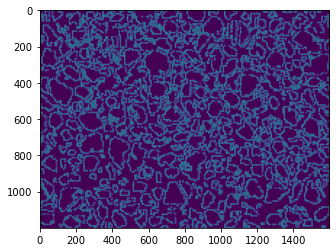

In [110]:
plt.imshow(diff_x)
plt.show()

In [111]:
cv2.imwrite('D:/GS/HED V2/output.jpg', diff_x)

True